### A
Cluster the text features. Can you find meaningful clusters?

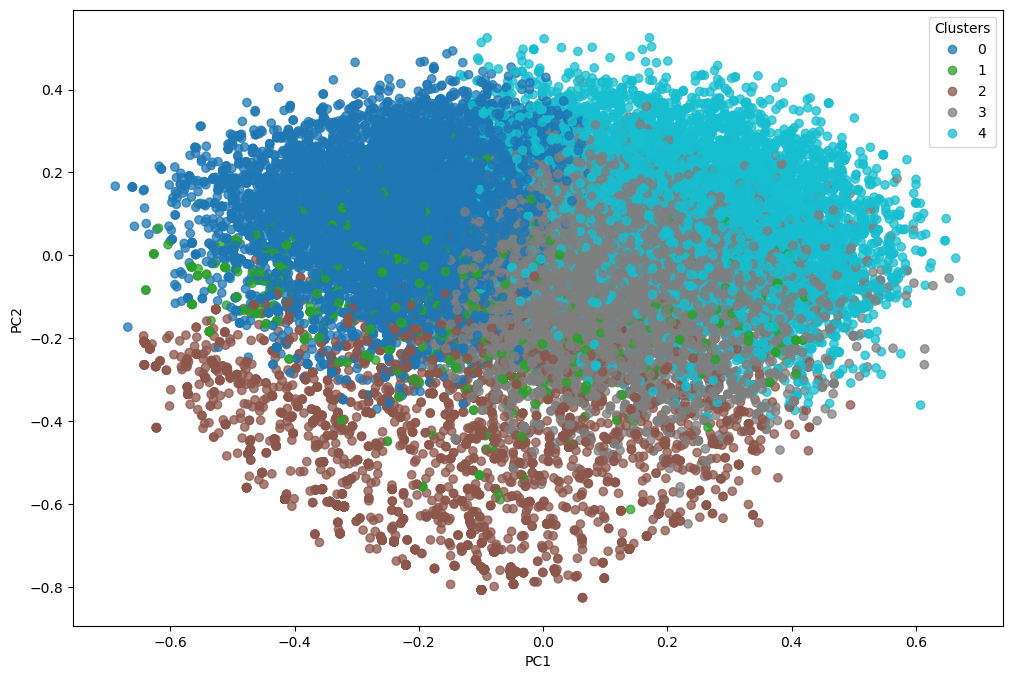

In [7]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt

# load metadata and annotations
dataset_path = 'MLPC2025_dataset'
metadata_df = pd.read_csv(os.path.join(dataset_path, 'metadata.csv'))
annotations_df = pd.read_csv(os.path.join(dataset_path, 'annotations.csv'))
annotations_embeddings = np.load(os.path.join(dataset_path, 'annotations_text_embeddings.npz'))['embeddings']

# cluster
number_of_clusters = 5
kmeans = sklearn.cluster.KMeans(n_clusters=number_of_clusters, random_state=0)
annotations_df['cluster'] = kmeans.fit_predict(annotations_embeddings)

# downsize with pca
pca = sklearn.decomposition.PCA(n_components=2)
reduced_embeddings = pca.fit_transform(annotations_embeddings)

# plot results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=annotations_df['cluster'], cmap='tab10', alpha=0.75)
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [17]:
for cluster_id in sorted(annotations_df['cluster'].unique()):
    samples = annotations_df[annotations_df['cluster'] == cluster_id]['text'].sample(5)
    print(f"\nCluster {cluster_id}:")
    for sample in samples:
        print(f"  - {sample}")


Cluster 0:
  - Distant Arabic speech occurring amidst a crowded, noisy environment.
  - General white noise resembling a dull blurred sound.
  - A wave splashing lodly.
  - A person who speaks very close
  - Sound of footsteps, walking on grass.

Cluster 1:
  - The dog is barking
  - A dog barks loudly once.
  - a dog runs past
  - Single dog bark
  - A dog barking intermittently in the background

Cluster 2:
  - Alarm clock beeps repeatedly in high pitch short beeps.
  - Quick chirping sounds of a bird
  - A cuckoo is chirping loudly close by
  - A bird chirps outdoors.
  - Multiple birds twittering outdoors

Cluster 3:
  - Continuous loud drilling with a pause in between.
  - Vehicles produce short horn honks in traffic
  - Rhythmic snoring sounds from a sleeping man, with occasional shifts in intensity.
  - People are chanting
  - A construction site with a jackhammer in use

Cluster 4:
  - Rain pouring continuously onto a hard surface during a rain storm
  - A close and clean echo

I clustered the text features using the KMeans algorithm with 5 clusters, mirroring the number previously used for audio features to allow for later comparison. To visualize the structure, I applied PCA to reduce the feature space to 2D and plotted the resulting clusters. Clusters 1 and 2 clearly contain very specific audio, namely noises of dogs and birds, or bird-like creatures, respectively. The other clusters contain less specific, but still differentiable audio. Cluster 0 contains calm, ambient sounds. Cluster 3 consists of loud, sudden noises. Lastly, Cluster 4 is made up of continouos mechinal audio. <br>
While some clusters, i.e. 0, 3, and 4, show more variability and are not completely uniform, the overall clustering demonstrates clear patterns and can be considered meaningful in terms of grouping similar audio descriptions.

### B
Design a labeling function for classes dog and cat. Do the annotations labeled as dog or cat sounds
form tight clusters in the text and audio feature space?

In [10]:
def label_dog(text: str) -> str:
    text = text.lower()
    if 'dog' in text or 'dog' in text:
        return True
    return False

def label_cat(text: str) -> str:
    text = text.lower()
    if 'cat' in text or 'cats' in text:
        return True
    return False

In [11]:
annotations_df['is_dog'] = annotations_df['text'].apply(label_dog)
annotations_df['is_cat'] = annotations_df['text'].apply(label_cat)

def get_animal_label(row):
    if row['is_dog']:
        return 'dog'
    elif row['is_cat']:
        return 'cat'
    return None

annotations_df['animal_label'] = annotations_df.apply(get_animal_label, axis=1)
filtered_df = annotations_df[annotations_df['animal_label'].notnull()]

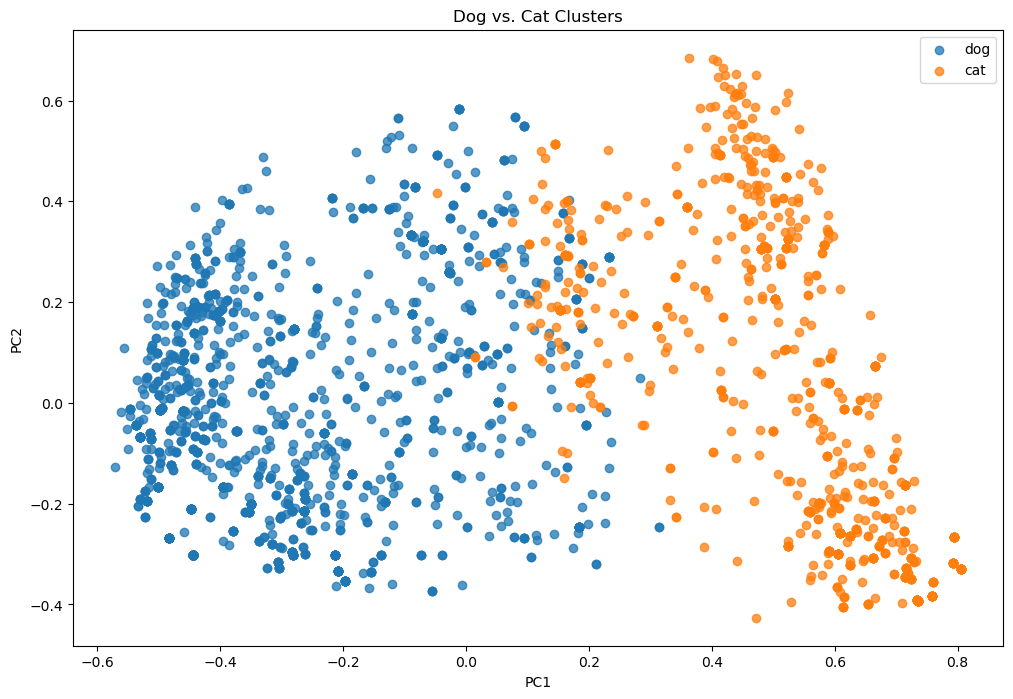

In [13]:
X = annotations_embeddings[filtered_df.index]
y = filtered_df["animal_label"]
pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X)

plt.figure(figsize=(12, 8))
for label in ["dog", "cat"]:
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.75)
plt.legend()
plt.title("Dog vs. Cat Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In the text feature space, the dog cluster is quite compact, while the cat cluster is more dispersed. Importantly, the two clusters are still clearly separable, indicating that the text embeddings effectively distinguish between dog- and cat-related descriptions. <br>
It is very similar in the audio feature space.

#### B2
Copying code from audio_features notebook

Found 9026 .npz files

Loading: 100300.npz

Keys in .npz file:
 - embeddings: shape (221, 768), dtype float32
 - melspectrogram: shape (221, 64), dtype float32
 - mfcc: shape (221, 32), dtype float32
 - mfcc_delta: shape (221, 32), dtype float32
 - mfcc_delta2: shape (221, 32), dtype float32
 - flatness: shape (221, 1), dtype float32
 - centroid: shape (221, 1), dtype float64
 - flux: shape (221, 1), dtype float32
 - energy: shape (221, 1), dtype float32
 - power: shape (221, 1), dtype float32
 - bandwidth: shape (221, 1), dtype float64
 - contrast: shape (221, 7), dtype float64
 - zerocrossingrate: shape (221, 1), dtype float64

Embedding shape: (221, 768)


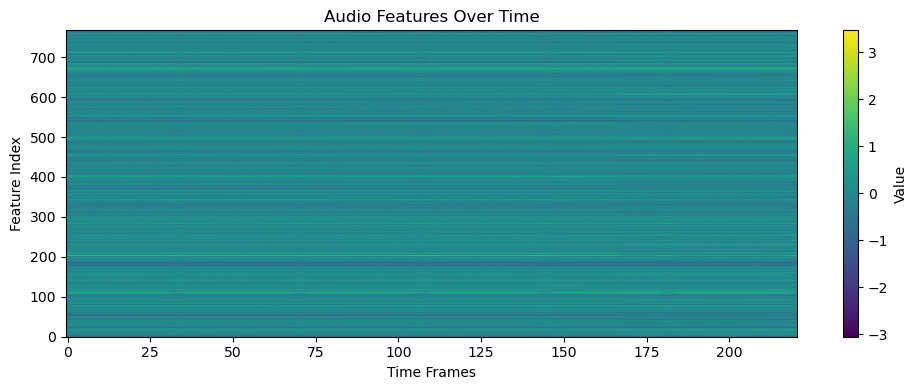

PCA explained variance (first 10 components): [0.6   0.206 0.093 0.038 0.018 0.01  0.005 0.004 0.003 0.003]


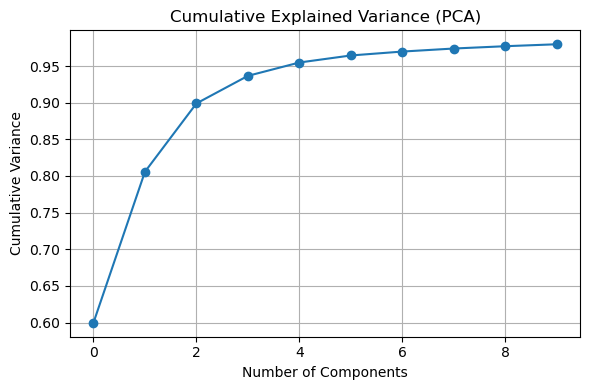

Extracted 31427 annotated vectors
Extracted 11277 silent vectors


In [1]:
feature_path = "MLPC2025_dataset/audio_features"

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

npz_files = [f for f in os.listdir(feature_path) if f.endswith('.npz')]
print(f"Found {len(npz_files)} .npz files")

sample_file = npz_files[0]
print(f"\nLoading: {sample_file}")

data = np.load(os.path.join(feature_path, sample_file))

print("\nKeys in .npz file:")
for key in data.files:
    print(f" - {key}: shape {data[key].shape}, dtype {data[key].dtype}")

if 'embeddings' in data:
    embeddings = data['embeddings']
else:
    for k in data.files:
        if data[k].ndim == 2:
            embeddings = data[k]
            print(f"Using fallback key: {k}")
            break
    else:
        raise ValueError("No suitable 2D feature array found.")

print(f"\nEmbedding shape: {embeddings.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(embeddings.T, aspect='auto', origin='lower', cmap='viridis')
plt.title("Audio Features Over Time")
plt.xlabel("Time Frames")
plt.ylabel("Feature Index")
plt.colorbar(label="Value")
plt.tight_layout()
plt.show()

#pca
pca = PCA(n_components=10)
reduced = pca.fit_transform(embeddings)
explained = pca.explained_variance_ratio_

print(f"PCA explained variance (first 10 components): {np.round(explained, 3)}")
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(explained), marker='o')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

import pandas as pd
from itertools import groupby
from operator import itemgetter

annotations_path = "MLPC2025_dataset/annotations.csv"
features_path = "MLPC2025_dataset/audio_features"

annotations = pd.read_csv(annotations_path)
annotated_vectors = []
silent_vectors = []

frame_duration = 0.96  # seconds per frame
grouped = annotations.groupby("filename")

for filename, group in grouped:
    file_id = os.path.splitext(filename)[0]
    npz_path = os.path.join(features_path, f"{file_id}.npz")
    
    if not os.path.exists(npz_path):
        continue

    try:
        data = np.load(npz_path)

        if "embeddings" in data:
            embeddings = data["embeddings"]
        else:
            emb_keys = [k for k in data.files if data[k].ndim == 2]
            if not emb_keys:
                continue
            embeddings = data[emb_keys[0]]

        num_frames = embeddings.shape[0]
        used_frames = np.zeros(num_frames, dtype=bool)

        for _, row in group.iterrows():
            onset = row["onset"]
            offset = row["offset"]
            start_idx = int(onset / frame_duration)
            end_idx = int(offset / frame_duration)
            start_idx = max(start_idx, 0)
            end_idx = min(end_idx, num_frames)

            if start_idx >= end_idx:
                continue

            segment = embeddings[start_idx:end_idx]
            mean_vector = segment.mean(axis=0)
            annotated_vectors.append(mean_vector)

            used_frames[start_idx:end_idx] = True

        silent_indices = np.where(~used_frames)[0]

        for k, g in groupby(enumerate(silent_indices), lambda ix: ix[0] - ix[1]):
            group_indices = list(map(itemgetter(1), g))
            if len(group_indices) >= 2:  # at least 2 frames to avg
                silent_segment = embeddings[group_indices]
                mean_vector = silent_segment.mean(axis=0)
                silent_vectors.append(mean_vector)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

#array
annotated_vectors = np.array(annotated_vectors)
silent_vectors = np.array(silent_vectors)

print(f"Extracted {len(annotated_vectors)} annotated vectors")
print(f"Extracted {len(silent_vectors)} silent vectors")


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\chris\anaconda3\envs\ml-st\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\chris\anaconda3\envs\ml-st\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\chris\anaconda3\envs\ml-st\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Users\chris\anaconda3\envs\ml-st\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
C:\Users\chris\anaconda3\envs\ml-st\Lib\site-packages\

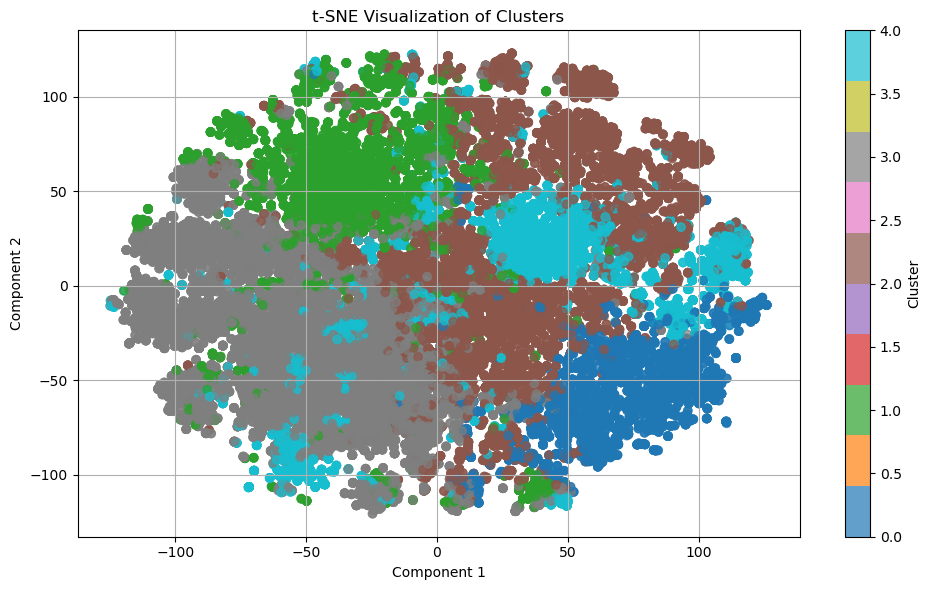


Cluster distribution for silent regions:
 - Cluster 0: 1486 silent vectors
 - Cluster 3: 3982 silent vectors
 - Cluster 1: 1283 silent vectors
 - Cluster 2: 3540 silent vectors
 - Cluster 4: 986 silent vectors

Cluster distribution for annotated regions:
 - Cluster 0: 3331 annotated vectors
 - Cluster 3: 9929 annotated vectors
 - Cluster 1: 5274 annotated vectors
 - Cluster 2: 8679 annotated vectors
 - Cluster 4: 4214 annotated vectors


In [2]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

# comb vectors
all_vectors = np.vstack([annotated_vectors, silent_vectors])
labels_true = (
    [1] * len(annotated_vectors) + 
    [0] * len(silent_vectors)
)  # 1 = annotated, 0 = silent

#kmeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_vectors)

#tnse
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_coords = tsne.fit_transform(all_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], 
            c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

silent_cluster_counts = Counter(np.array(cluster_labels)[np.array(labels_true) == 0])
annotated_cluster_counts = Counter(np.array(cluster_labels)[np.array(labels_true) == 1])

print("\nCluster distribution for silent regions:")
for k, v in silent_cluster_counts.items():
    print(f" - Cluster {k}: {v} silent vectors")

print("\nCluster distribution for annotated regions:")
for k, v in annotated_cluster_counts.items():
    print(f" - Cluster {k}: {v} annotated vectors")

### C
How well do the audio feature clusters align with text clusters?